In [1]:
# Mathematical Demonstrations for Lectures
# Clean, pedagogical implementations

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.stats import norm, laplace

# Set style
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
# %% [markdown]
# ## 1. MLE vs MAP Demonstration

# %%
def visualize_mle_vs_map():
    """
    Demonstrate how MAP estimation naturally leads to L2 regularization
    """

    # Generate synthetic 1D data for clarity
    np.random.seed(42)
    n_samples = 20
    X = np.linspace(-2, 2, n_samples).reshape(-1, 1)
    true_weights = np.array([1.5])
    y = X @ true_weights + 0.3 * np.random.randn(n_samples, 1)

    # Define negative log-likelihood (MLE objective)
    def nll(theta, X, y, sigma2=1.0):
        """Negative log-likelihood for Gaussian noise"""
        predictions = X @ theta.reshape(-1, 1)
        return np.sum((y - predictions)**2) / (2 * sigma2)

    # Define negative log-posterior (MAP objective)
    def nlp(theta, X, y, sigma2=1.0, tau2=1.0):
        """Negative log-posterior with Gaussian prior"""
        nll_term = nll(theta, X, y, sigma2)
        prior_term = np.sum(theta**2) / (2 * tau2)
        return nll_term + prior_term

    # Grid search for visualization
    theta_range = np.linspace(-3, 3, 200)

    # Different prior strengths (tau² values)
    tau2_values = [0.1, 1.0, 10.0]

    fig, axes = plt.subplots(2, 3, figsize=(18, 15))

    # Plot for different prior strengths
    for idx, tau2 in enumerate(tau2_values):
        # Compute objectives
        nll_values = [nll(np.array([theta]), X, y) for theta in theta_range]
        nlp_values = [nlp(np.array([theta]), X, y, tau2=tau2) for theta in theta_range]
        prior_values = [theta**2 / (2 * tau2) for theta in theta_range]

        # Find optima
        theta_mle = theta_range[np.argmin(nll_values)]
        theta_map = theta_range[np.argmin(nlp_values)]

        # Top row: Objective functions
        ax = axes[0, idx]
        ax.plot(theta_range, nll_values, 'b-', label='NLL (MLE)', linewidth=2)
        ax.plot(theta_range, nlp_values, 'r-', label='NLP (MAP)', linewidth=2)
        ax.plot(theta_range, prior_values, 'g--', label='Prior term', alpha=0.7)
        ax.axvline(theta_mle, color='blue', linestyle=':', alpha=0.7)
        ax.axvline(theta_map, color='red', linestyle=':', alpha=0.7)
        ax.axvline(true_weights[0], color='black', linestyle='--', alpha=0.5, label='True')
        ax.set_xlabel('θ')
        ax.set_ylabel('Loss')
        ax.set_title(f'τ² = {tau2} (λ = {1/tau2:.2f})')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Bottom row: Prior distributions
        ax = axes[1, idx]
        prior_pdf = norm.pdf(theta_range, 0, np.sqrt(tau2))
        ax.fill_between(theta_range, prior_pdf, alpha=0.3, color='green')
        ax.plot(theta_range, prior_pdf, 'g-', linewidth=2, label=f'N(0, {tau2})')
        ax.axvline(theta_map, color='red', linestyle='-', alpha=0.7, label=f'θ_MAP = {theta_map:.2f}')
        ax.axvline(theta_mle, color='blue', linestyle='--', alpha=0.7, label=f'θ_MLE = {theta_mle:.2f}')
        ax.set_xlabel('θ')
        ax.set_ylabel('Prior P(θ)')
        ax.set_title(f'Gaussian Prior (stronger prior → more shrinkage)')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.suptitle('MLE vs MAP: How Gaussian Prior Leads to L2 Regularization', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print the mathematical relationship
    print("Mathematical Relationship:")
    print("="*50)
    print("MLE objective: min_θ NLL = min_θ Σ(y - Xθ)²")
    print("MAP objective: min_θ NLL + NegLogPrior")
    print("              = min_θ Σ(y - Xθ)² + θ²/(2τ²)")
    print("              = min_θ Σ(y - Xθ)² + λ||θ||²")
    print(f"where λ = σ²/τ² = regularization strength")
    print("="*50)
    print("\nObservations:")
    print("- Small τ² (strong prior) → large λ → more regularization")
    print("- Large τ² (weak prior) → small λ → less regularization")
    print("- τ² → ∞ (flat prior) → λ → 0 → MLE")


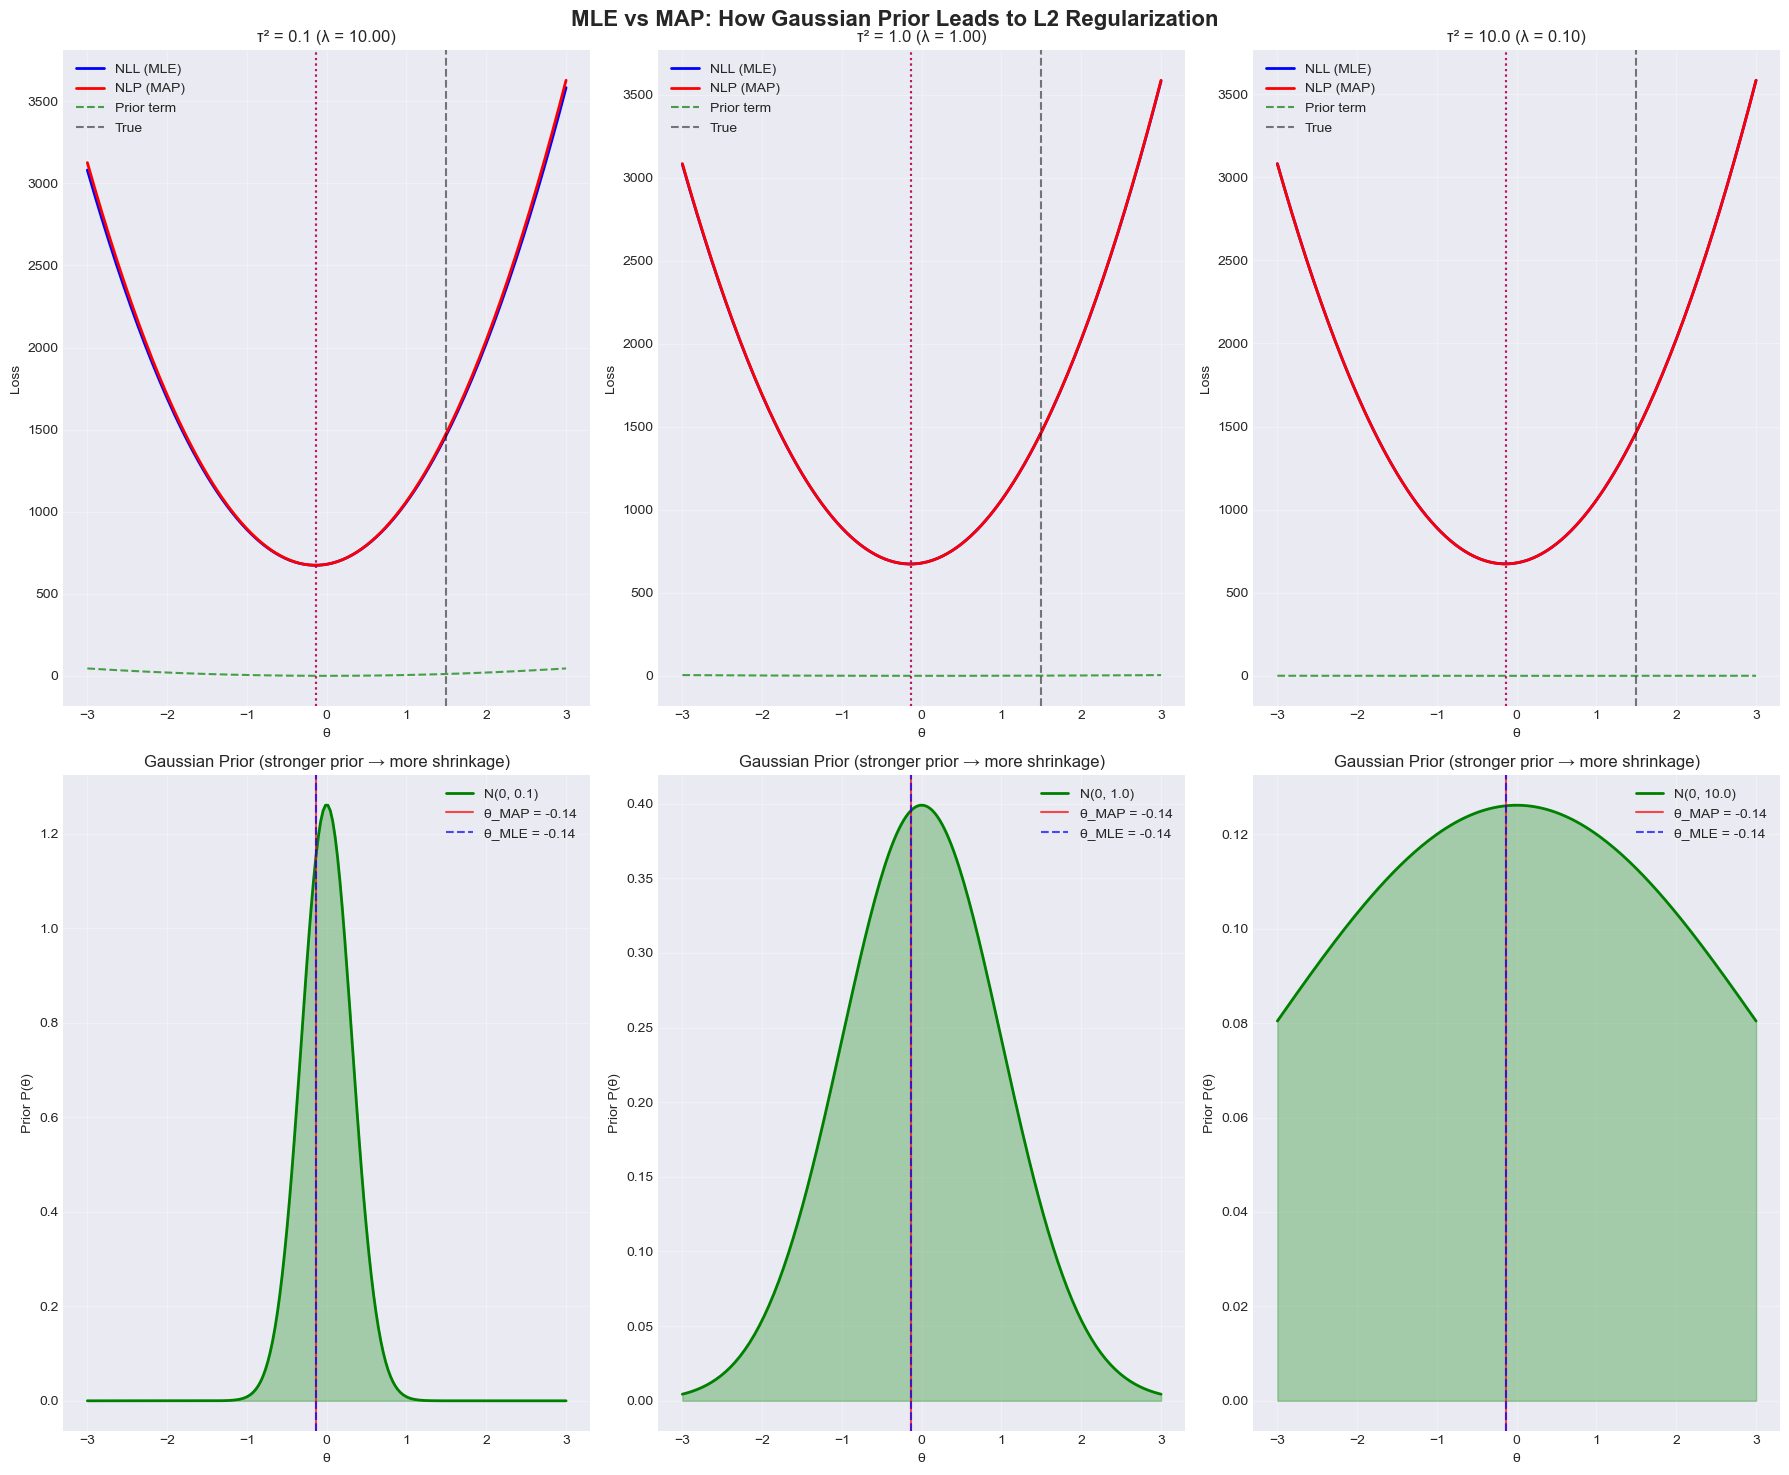

Mathematical Relationship:
MLE objective: min_θ NLL = min_θ Σ(y - Xθ)²
MAP objective: min_θ NLL + NegLogPrior
              = min_θ Σ(y - Xθ)² + θ²/(2τ²)
              = min_θ Σ(y - Xθ)² + λ||θ||²
where λ = σ²/τ² = regularization strength

Observations:
- Small τ² (strong prior) → large λ → more regularization
- Large τ² (weak prior) → small λ → less regularization
- τ² → ∞ (flat prior) → λ → 0 → MLE


In [4]:
visualize_mle_vs_map()


In [5]:
# %%
def compare_different_priors():
    """Show how different priors lead to different regularization types"""

    theta_range = np.linspace(-3, 3, 200)

    fig, axes = plt.subplots(1, 3, figsize=(22, 9))

    # Gaussian prior → L2 regularization
    ax = axes[0]
    gaussian_prior = norm.pdf(theta_range, 0, 1)
    gaussian_penalty = theta_range**2

    ax.plot(theta_range, gaussian_prior, 'b-', linewidth=2, label='Prior: N(0,1)')
    ax_twin = ax.twinx()
    ax_twin.plot(theta_range, gaussian_penalty, 'r--', linewidth=2, label='Penalty: θ²')
    ax.set_xlabel('θ')
    ax.set_ylabel('P(θ)', color='b')
    ax_twin.set_ylabel('-log P(θ) ∝ Penalty', color='r')
    ax.set_title('Gaussian Prior → L2 Regularization')
    ax.grid(True, alpha=0.3)

    # Laplace prior → L1 regularization
    ax = axes[1]
    laplace_prior = laplace.pdf(theta_range, 0, 1)
    laplace_penalty = np.abs(theta_range)

    ax.plot(theta_range, laplace_prior, 'b-', linewidth=2, label='Prior: Laplace(0,1)')
    ax_twin = ax.twinx()
    ax_twin.plot(theta_range, laplace_penalty, 'r--', linewidth=2, label='Penalty: |θ|')
    ax.set_xlabel('θ')
    ax.set_ylabel('P(θ)', color='b')
    ax_twin.set_ylabel('-log P(θ) ∝ Penalty', color='r')
    ax.set_title('Laplace Prior → L1 Regularization (Sparsity)')
    ax.grid(True, alpha=0.3)

    # Student-t prior → Robust regression
    ax = axes[2]
    from scipy.stats import t as student_t
    t_prior = student_t.pdf(theta_range, df=2, loc=0, scale=1)
    t_penalty = np.log(1 + theta_range**2)

    ax.plot(theta_range, t_prior, 'b-', linewidth=2, label='Prior: Student-t(ν=2)')
    ax_twin = ax.twinx()
    ax_twin.plot(theta_range, t_penalty, 'r--', linewidth=2, label='Penalty: log(1+θ²)')
    ax.set_xlabel('θ')
    ax.set_ylabel('P(θ)', color='b')
    ax_twin.set_ylabel('-log P(θ) ∝ Penalty', color='r')
    ax.set_title('Student-t Prior → Robust Regression')
    ax.grid(True, alpha=0.3)

    plt.suptitle('Different Priors Lead to Different Regularization', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


/var/folders/0c/sf75c36s7hj79vhf3ltwjyw00000gn/T/ipykernel_25431/3389553726.py:53: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/igor/miniforge3/envs/mini/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


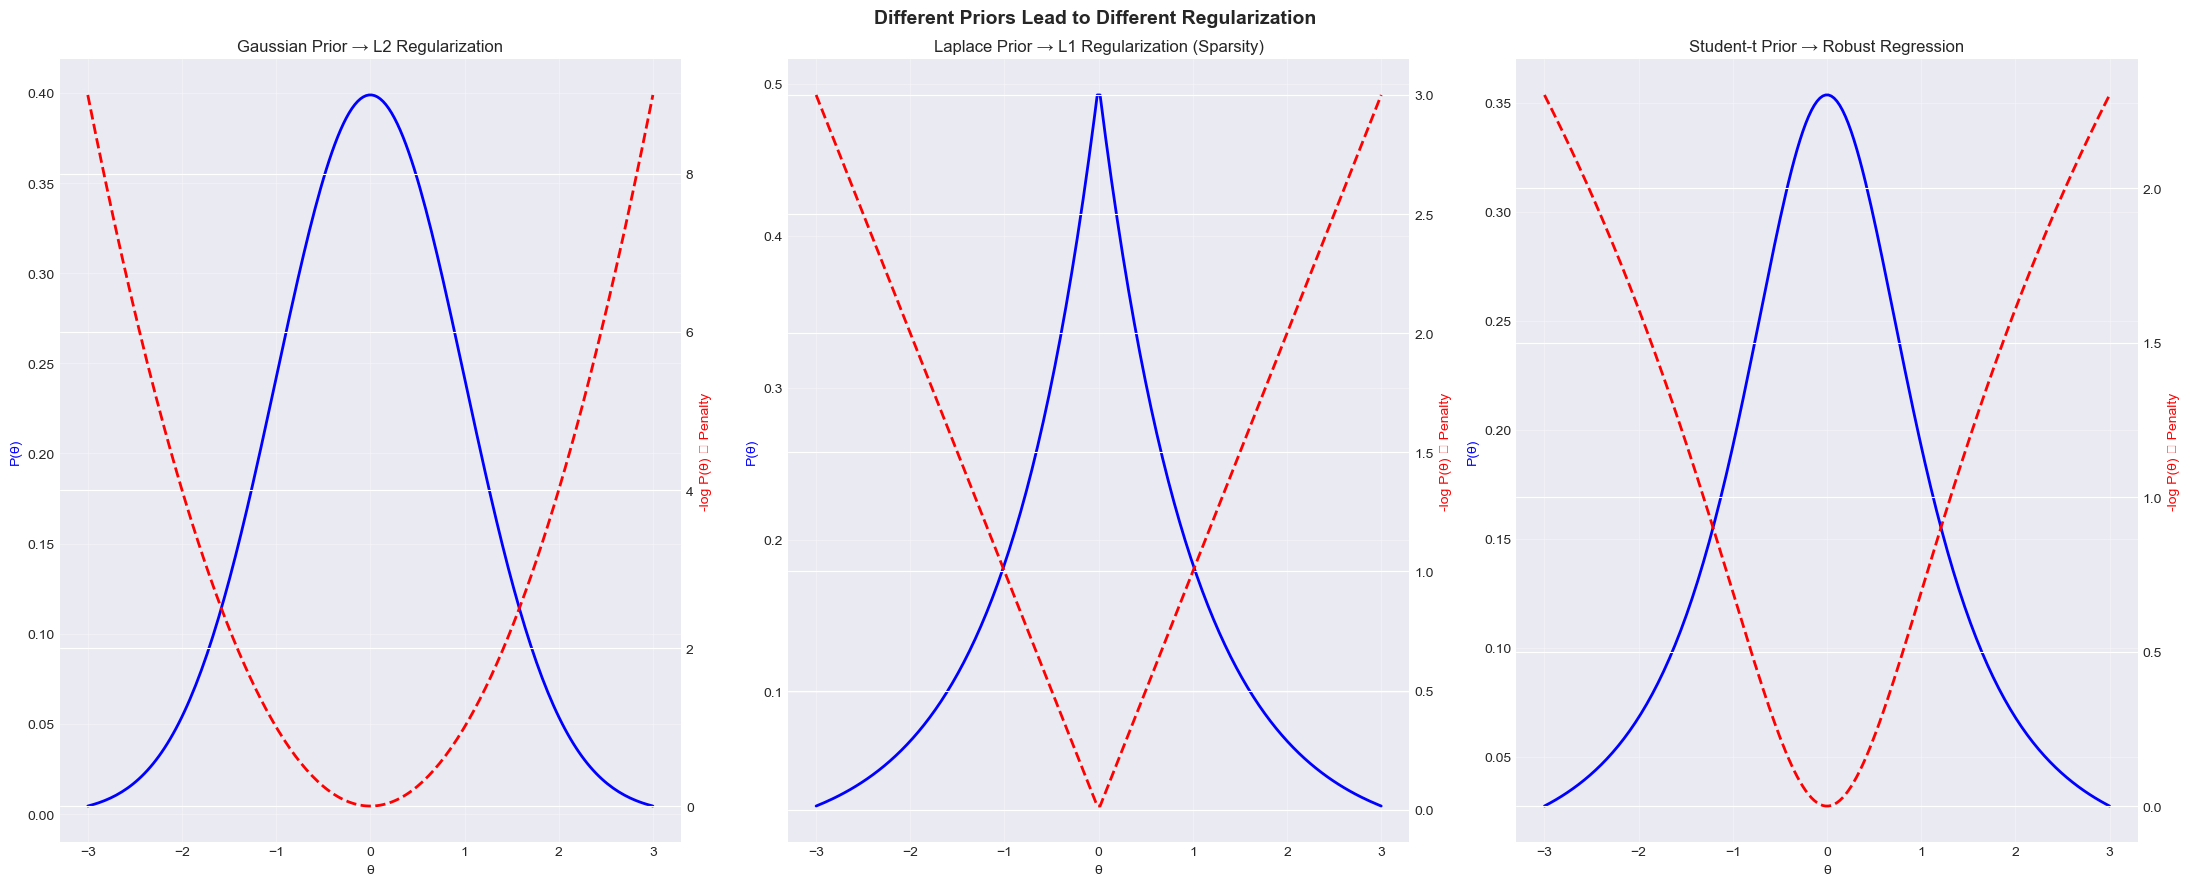

In [6]:
compare_different_priors()


In [7]:
# %% [markdown]
# ## 2. Lottery Ticket Hypothesis - Mathematical Demonstration

# %%
def demonstrate_lottery_ticket_math():
    """
    Show the mathematical essence of lottery tickets
    """

    torch.manual_seed(42)

    # Create a simple network for visualization
    input_size = 10
    hidden_size = 100
    output_size = 1

    # Initialize network
    W1_init = torch.randn(hidden_size, input_size) * 0.1
    W2_init = torch.randn(output_size, hidden_size) * 0.1

    # Simulate "training" (just add some structure)
    # In reality, this would be gradient descent
    W1_trained = W1_init + torch.randn_like(W1_init) * 0.5
    W2_trained = W2_init + torch.randn_like(W2_init) * 0.5

    # Make some weights large (important) and others small
    important_indices_1 = torch.randperm(hidden_size)[:20]
    important_indices_2 = torch.randperm(hidden_size)[:20]
    W1_trained[important_indices_1, :] *= 5
    W2_trained[:, important_indices_2] *= 5

    # Create pruning masks at different sparsity levels
    sparsity_levels = [0, 0.5, 0.8, 0.9, 0.95, 0.98]

    fig, axes = plt.subplots(2, 3, figsize=(22, 15))
    axes = axes.flatten()

    for idx, sparsity in enumerate(sparsity_levels):
        ax = axes[idx]

        if sparsity == 0:
            mask1 = torch.ones_like(W1_trained)
            mask2 = torch.ones_like(W2_trained)
        else:
            # Magnitude-based pruning
            all_weights = torch.cat([W1_trained.flatten(), W2_trained.flatten()])
            threshold = torch.quantile(torch.abs(all_weights), sparsity)
            mask1 = torch.abs(W1_trained) > threshold
            mask2 = torch.abs(W2_trained) > threshold

        # Apply masks
        W1_lottery = W1_init * mask1.float()
        W2_lottery = W2_init * mask2.float()

        # Visualize the lottery ticket network structure
        # Combine weights for visualization
        weights_viz = torch.cat([W1_lottery.flatten(), W2_lottery.flatten()])

        # Plot weight distribution
        weights_np = weights_viz.numpy()
        non_zero = weights_np[weights_np != 0]

        if len(non_zero) > 0:
            ax.hist(non_zero, bins=30, alpha=0.7, color='blue', density=True)
        ax.axvline(0, color='red', linestyle='--', linewidth=2)

        remaining = (1 - sparsity) * 100
        active_params = mask1.sum() + mask2.sum()
        total_params = mask1.numel() + mask2.numel()

        ax.set_title(f'Sparsity: {sparsity*100:.0f}%\n'
                     f'Active: {active_params}/{total_params} params', fontweight='bold')
        ax.set_xlabel('Weight Value')
        ax.set_ylabel('Density')
        ax.grid(True, alpha=0.3)

        # Add text box with key insight
        if sparsity > 0:
            textstr = f'Lottery Ticket:\n{remaining:.0f}% of original\nSame initialization'
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
                   verticalalignment='top', bbox=props)

    plt.suptitle('Lottery Ticket at Different Sparsity Levels\n'
                 '(Showing Initial Weights of Winning Tickets)',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Mathematical demonstration
    print("\nLottery Ticket Mathematics:")
    print("="*60)
    print("Original network: f(x; θ₀) where θ₀ ~ N(0, σ²)")
    print("After training: θ_T = train(θ₀, data)")
    print("Pruning mask: m = 1[|θ_T| > τ] (magnitude threshold)")
    print("\nLottery ticket: f(x; m ⊙ θ₀)")
    print("  - Uses SAME initialization θ₀")
    print("  - Only subset active via mask m")
    print("\nKey finding: f(x; m ⊙ θ₀) trains well ✓")
    print("            f(x; m ⊙ θ'₀) trains poorly ✗")
    print("="*60)


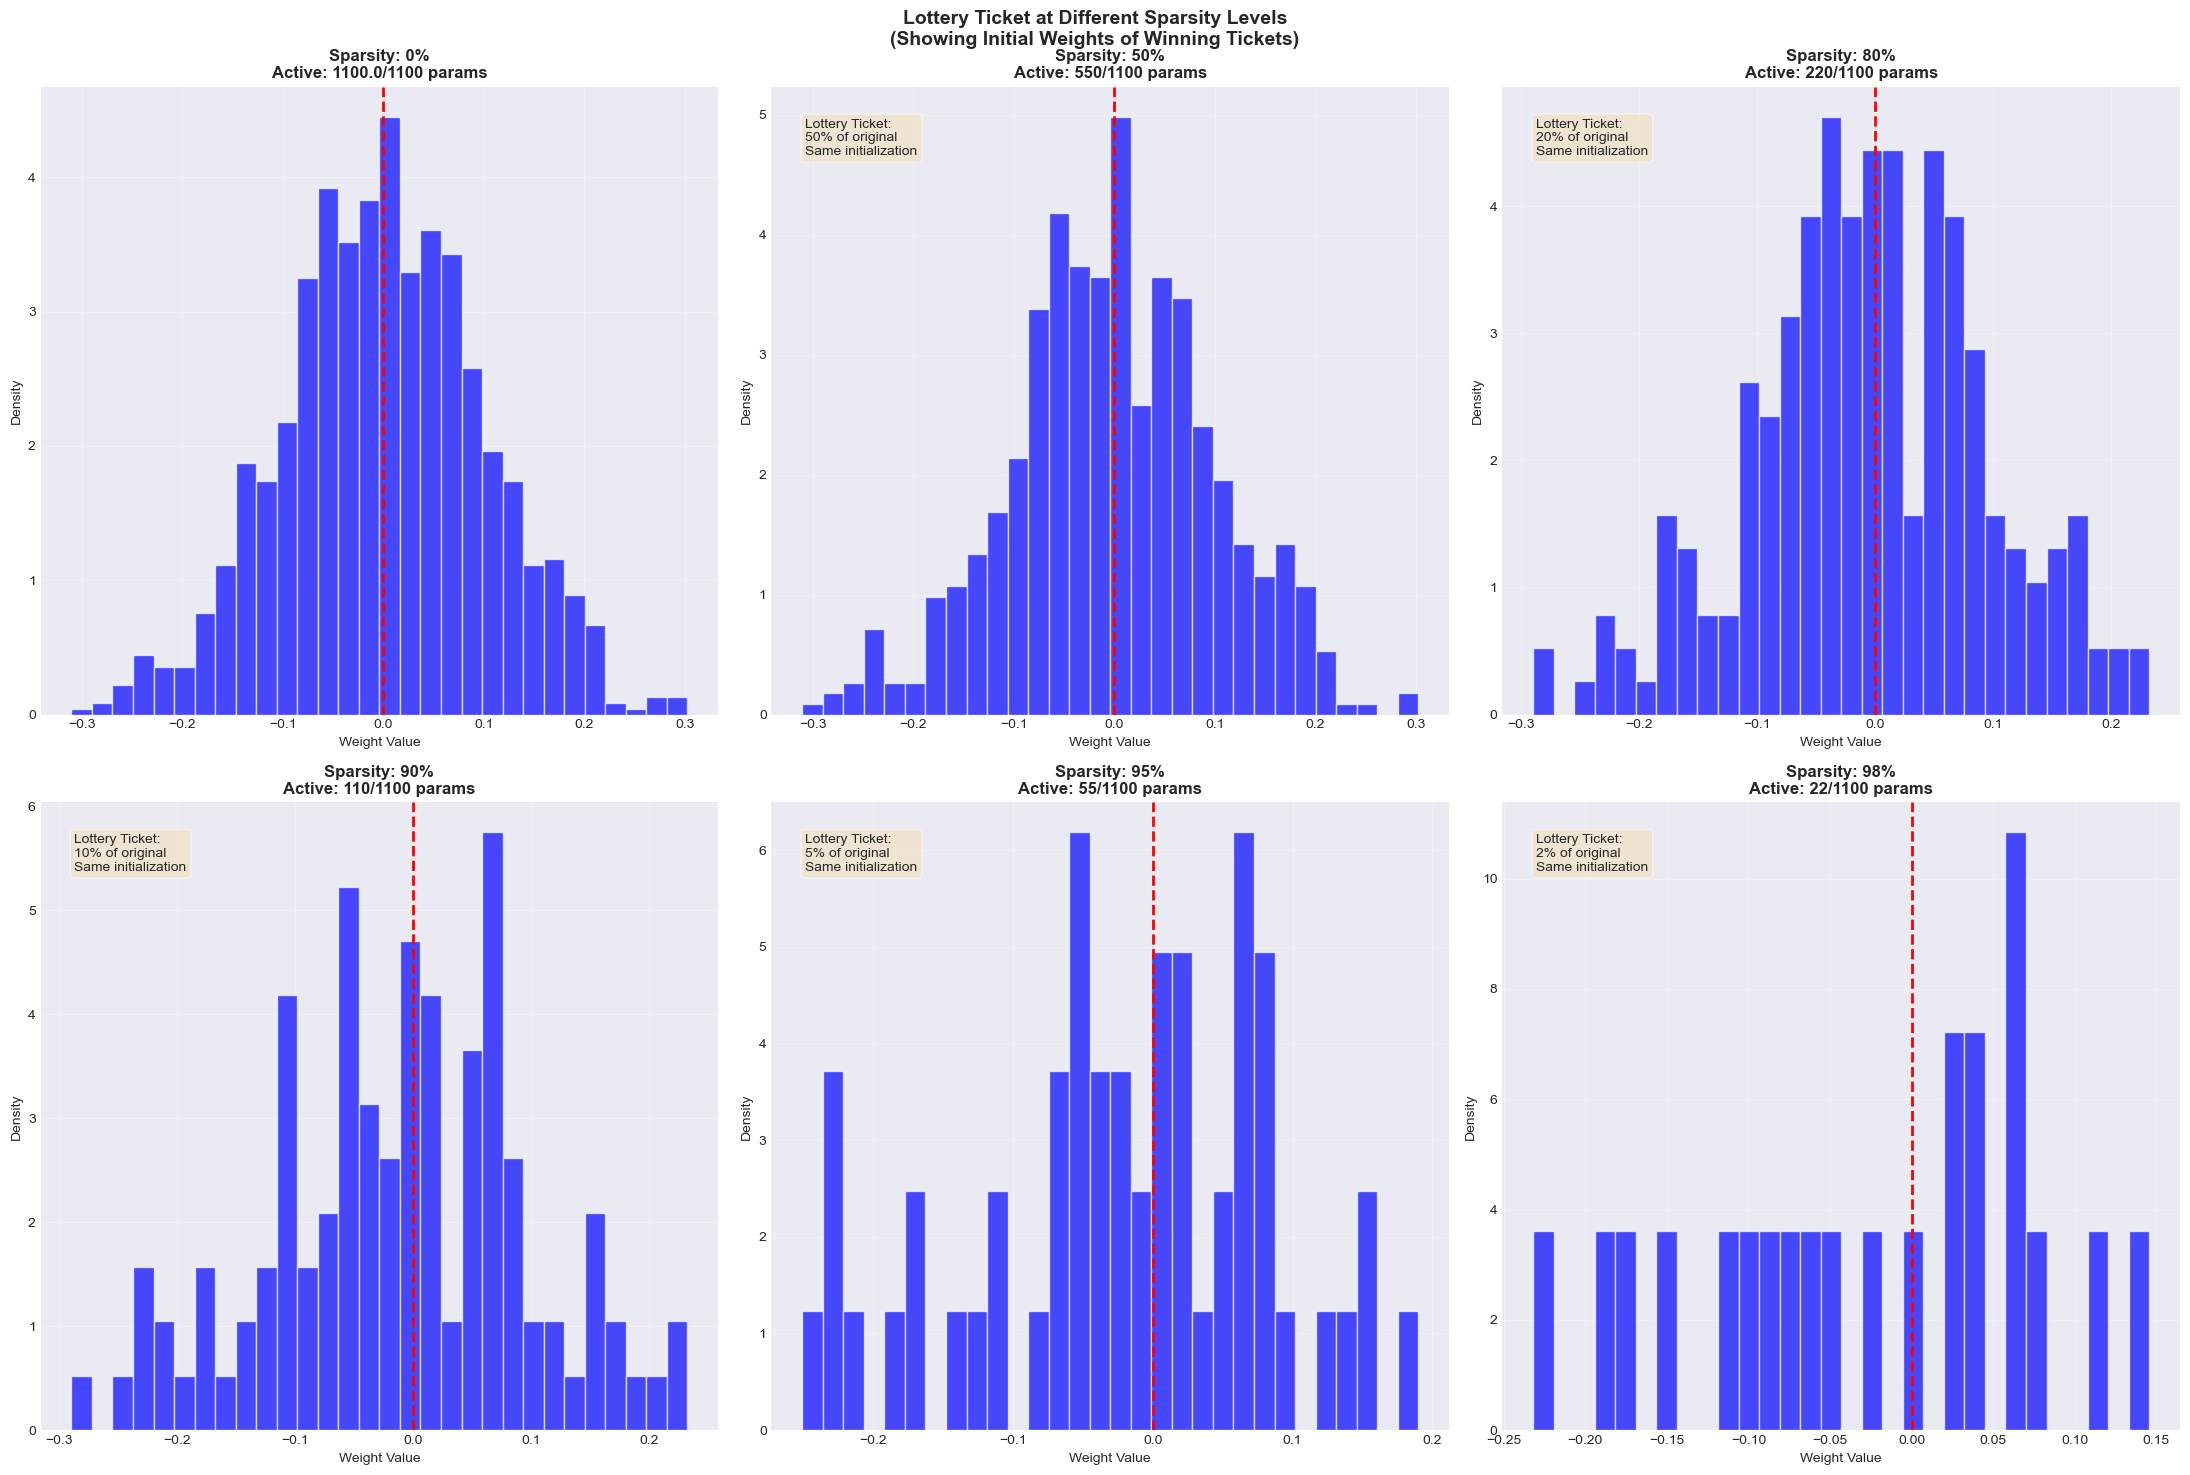


Lottery Ticket Mathematics:
Original network: f(x; θ₀) where θ₀ ~ N(0, σ²)
After training: θ_T = train(θ₀, data)
Pruning mask: m = 1[|θ_T| > τ] (magnitude threshold)

Lottery ticket: f(x; m ⊙ θ₀)
  - Uses SAME initialization θ₀
  - Only subset active via mask m

Key finding: f(x; m ⊙ θ₀) trains well ✓
            f(x; m ⊙ θ'₀) trains poorly ✗


In [8]:
demonstrate_lottery_ticket_math()


In [9]:
# %%
def lottery_ticket_probability():
    """
    Show why overparameterization increases lottery ticket probability
    """

    # Model the probability of finding a good subnetwork
    network_sizes = np.logspace(2, 6, 50)  # 100 to 1M parameters
    sparsity = 0.1  # Keep 10% of parameters

    # Probability that a random subnetwork is "good" (simplified model)
    p_single_good = 0.001  # 0.1% chance

    # Number of possible subnetworks (combinations)
    # Using Stirling's approximation for large numbers
    def num_subnetworks(n, s):
        k = int(s * n)
        if k == 0 or k == n:
            return 1
        # Stirling's approximation for binomial coefficient
        return np.sqrt(2 * np.pi * n) / (np.sqrt(2 * np.pi * k) * np.sqrt(2 * np.pi * (n - k))) * \
               (n / k) ** k * (n / (n - k)) ** (n - k)

    # Probability of at least one good subnetwork
    prob_success = []
    for n in network_sizes:
        n_subnets = min(num_subnetworks(n, sparsity), 1e10)  # Cap for numerical stability
        # P(at least one good) = 1 - P(all bad)
        p_at_least_one = 1 - (1 - p_single_good) ** n_subnets
        prob_success.append(min(p_at_least_one, 1.0))

    fig, axes = plt.subplots(1, 2, figsize=(21, 10))

    # Probability of success vs network size
    ax = axes[0]
    ax.semilogx(network_sizes, prob_success, 'b-', linewidth=3)
    ax.fill_between(network_sizes, 0, prob_success, alpha=0.3)
    ax.set_xlabel('Network Size (# parameters)', fontsize=12)
    ax.set_ylabel('P(Contains Winning Ticket)', fontsize=12)
    ax.set_title('Lottery Ticket Probability vs Network Size', fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(0.5, color='red', linestyle='--', alpha=0.5)
    ax.axhline(0.99, color='green', linestyle='--', alpha=0.5)

    # Expected number of good tickets
    ax = axes[1]
    expected_good = [min(num_subnetworks(n, sparsity), 1e10) * p_single_good
                     for n in network_sizes]
    ax.loglog(network_sizes, expected_good, 'g-', linewidth=3)
    ax.set_xlabel('Network Size (# parameters)', fontsize=12)
    ax.set_ylabel('Expected # of Winning Tickets', fontsize=12)
    ax.set_title('Expected Winning Tickets (log-log scale)', fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(1, color='red', linestyle='--', alpha=0.5, label='One ticket')
    ax.legend()

    plt.suptitle('Why Overparameterization Helps: More Lottery Tickets!',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\nMathematical Insight:")
    print("="*60)
    print(f"For a network with n parameters, keeping {sparsity*100}% sparse:")
    print(f"  Number of possible subnetworks ≈ C(n, {sparsity}n)")
    print(f"  If P(single subnet good) = {p_single_good}")
    print(f"  Then P(at least one good) = 1 - (1-p)^(n_subsets)")
    print(f"\nAs n increases:")
    print(f"  - 100 params: P(success) ≈ {prob_success[0]:.3f}")
    print(f"  - 10K params: P(success) ≈ {prob_success[25]:.3f}")
    print(f"  - 1M params: P(success) ≈ {prob_success[-1]:.3f}")
    print("="*60)


/var/folders/0c/sf75c36s7hj79vhf3ltwjyw00000gn/T/ipykernel_25431/429546632.py:21: RuntimeWarning: overflow encountered in scalar multiply
  return np.sqrt(2 * np.pi * n) / (np.sqrt(2 * np.pi * k) * np.sqrt(2 * np.pi * (n - k))) * \
/var/folders/0c/sf75c36s7hj79vhf3ltwjyw00000gn/T/ipykernel_25431/429546632.py:22: RuntimeWarning: overflow encountered in scalar power
  (n / k) ** k * (n / (n - k)) ** (n - k)


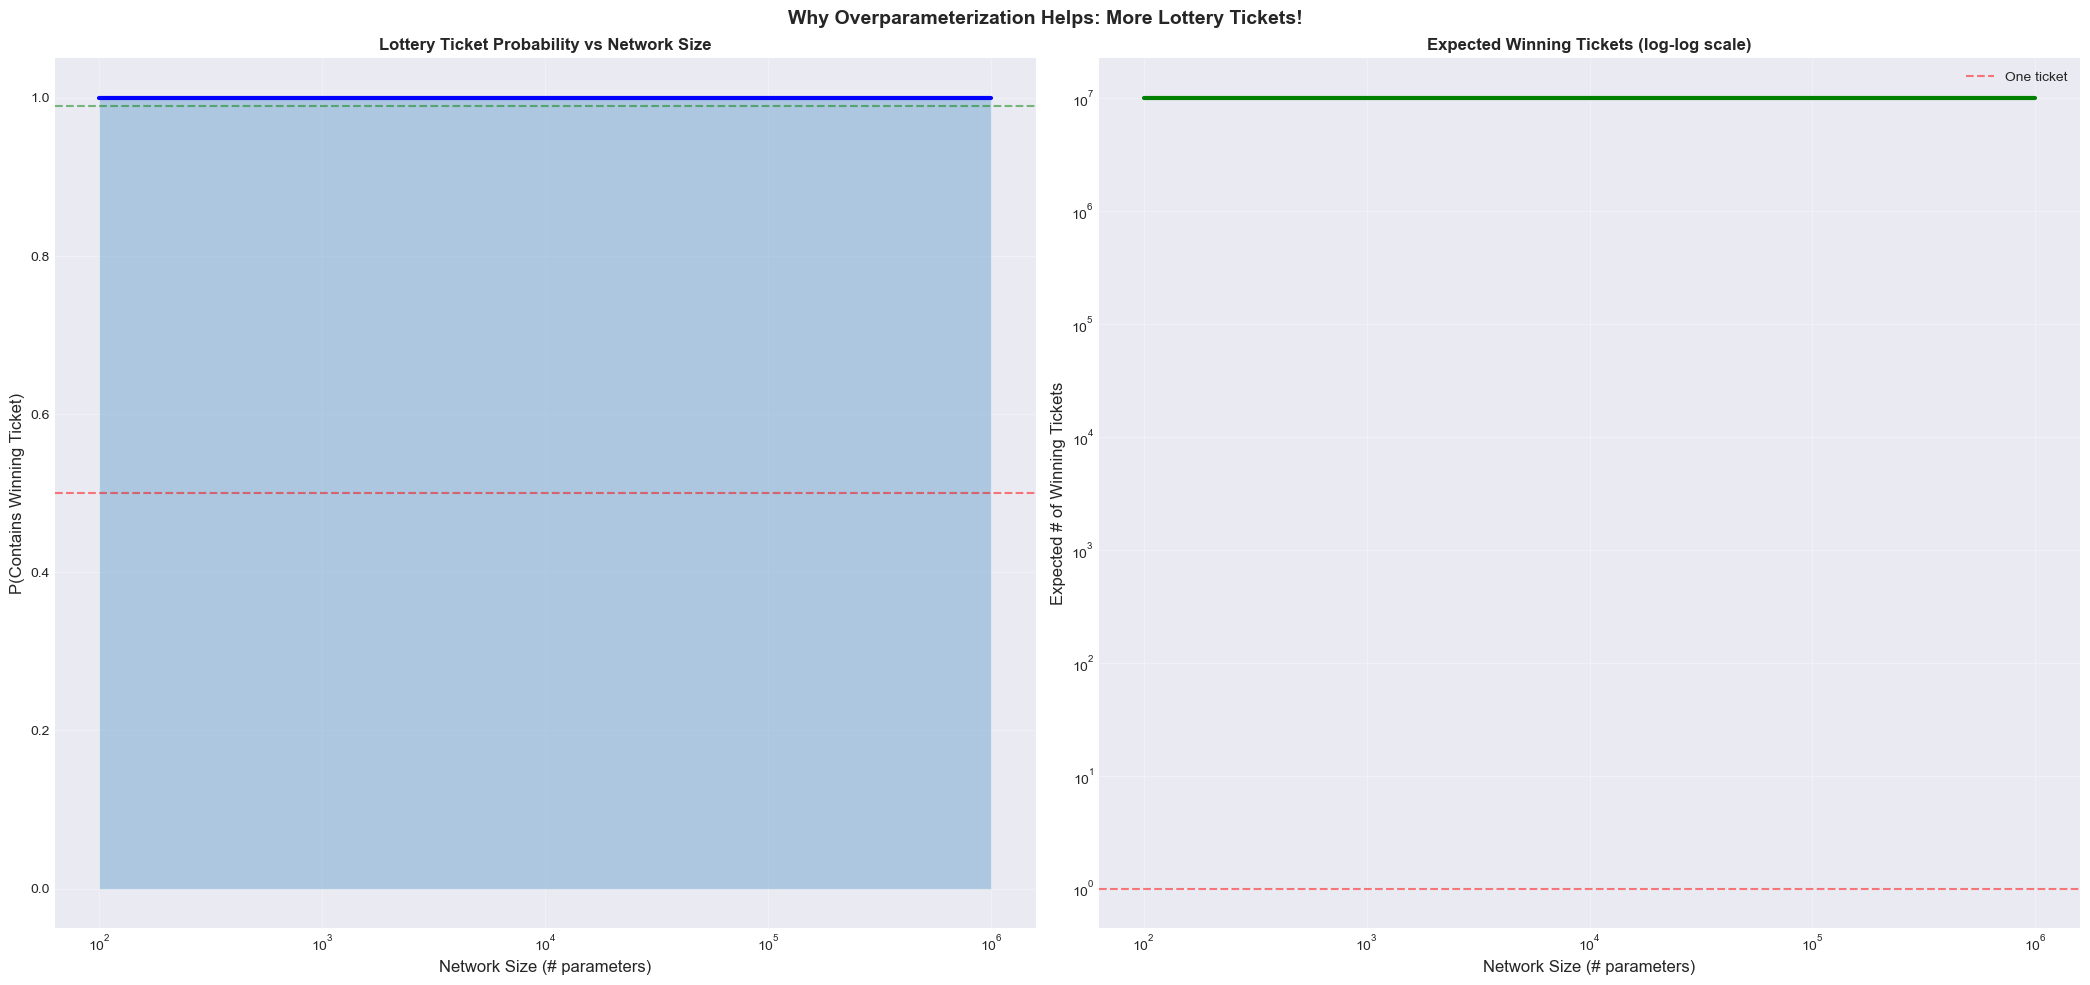


Mathematical Insight:
For a network with n parameters, keeping 10.0% sparse:
  Number of possible subnetworks ≈ C(n, 0.1n)
  If P(single subnet good) = 0.001
  Then P(at least one good) = 1 - (1-p)^(n_subsets)

As n increases:
  - 100 params: P(success) ≈ 1.000
  - 10K params: P(success) ≈ 1.000
  - 1M params: P(success) ≈ 1.000


In [10]:
lottery_ticket_probability()


In [11]:
# %% [markdown]
# ## 3. Neural Tangent Kernel - Mathematical Demonstration

# %%
def compute_ntk_matrix():
    """
    Compute and visualize the Neural Tangent Kernel
    """

    torch.manual_seed(42)

    # Simple 2-layer network for NTK computation
    class SimpleNet(nn.Module):
        def __init__(self, width):
            super().__init__()
            self.fc1 = nn.Linear(2, width)
            self.fc2 = nn.Linear(width, 1)

            # NTK initialization
            nn.init.normal_(self.fc1.weight, 0, np.sqrt(2/2))
            nn.init.normal_(self.fc2.weight, 0, np.sqrt(2/width))
            nn.init.zeros_(self.fc1.bias)
            nn.init.zeros_(self.fc2.bias)

        def forward(self, x):
            return self.fc2(torch.relu(self.fc1(x)))

    # Generate sample points
    n_samples = 10
    X = torch.randn(n_samples, 2)

    # Compute NTK for different widths
    widths = [10, 50, 200, 1000]

    fig, axes = plt.subplots(2, 4, figsize=(24, 15))

    for idx, width in enumerate(widths):
        model = SimpleNet(width)

        # Compute NTK matrix
        K = torch.zeros(n_samples, n_samples)

        for i in range(n_samples):
            for j in range(n_samples):
                # Reset gradients
                model.zero_grad()

                # Compute gradient for x_i
                out_i = model(X[i:i+1])
                grads_i = torch.autograd.grad(out_i, model.parameters(),
                                              retain_graph=True, create_graph=True)

                # Compute gradient for x_j
                out_j = model(X[j:j+1])
                grads_j = torch.autograd.grad(out_j, model.parameters(),
                                              retain_graph=True, create_graph=True)

                # Compute kernel value as dot product of gradients
                kernel_value = sum((g_i * g_j).sum() for g_i, g_j in zip(grads_i, grads_j))
                K[i, j] = kernel_value.item()

        # Visualize kernel matrix
        ax = axes[0, idx]
        im = ax.imshow(K.numpy(), cmap='viridis', aspect='auto')
        ax.set_title(f'NTK Matrix (Width={width})', fontweight='bold')
        ax.set_xlabel('Sample j')
        ax.set_ylabel('Sample i')
        plt.colorbar(im, ax=ax)

        # Show eigenvalue spectrum
        ax = axes[1, idx]
        eigenvalues = torch.linalg.eigvalsh(K).numpy()
        ax.semilogy(eigenvalues[::-1], 'o-', linewidth=2)
        ax.set_xlabel('Eigenvalue Index')
        ax.set_ylabel('Eigenvalue (log scale)')
        ax.set_title(f'Spectrum (Width={width})', fontweight='bold')
        ax.grid(True, alpha=0.3)

        # Add condition number
        cond = eigenvalues.max() / (eigenvalues.min() + 1e-10)
        ax.text(0.5, 0.05, f'κ = {cond:.1e}', transform=ax.transAxes,
               bbox=dict(boxstyle='round', facecolor='wheat'))

    plt.suptitle('Neural Tangent Kernel: Effect of Network Width\n'
                 'Wider Networks → Smoother Kernel → Better Conditioning',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


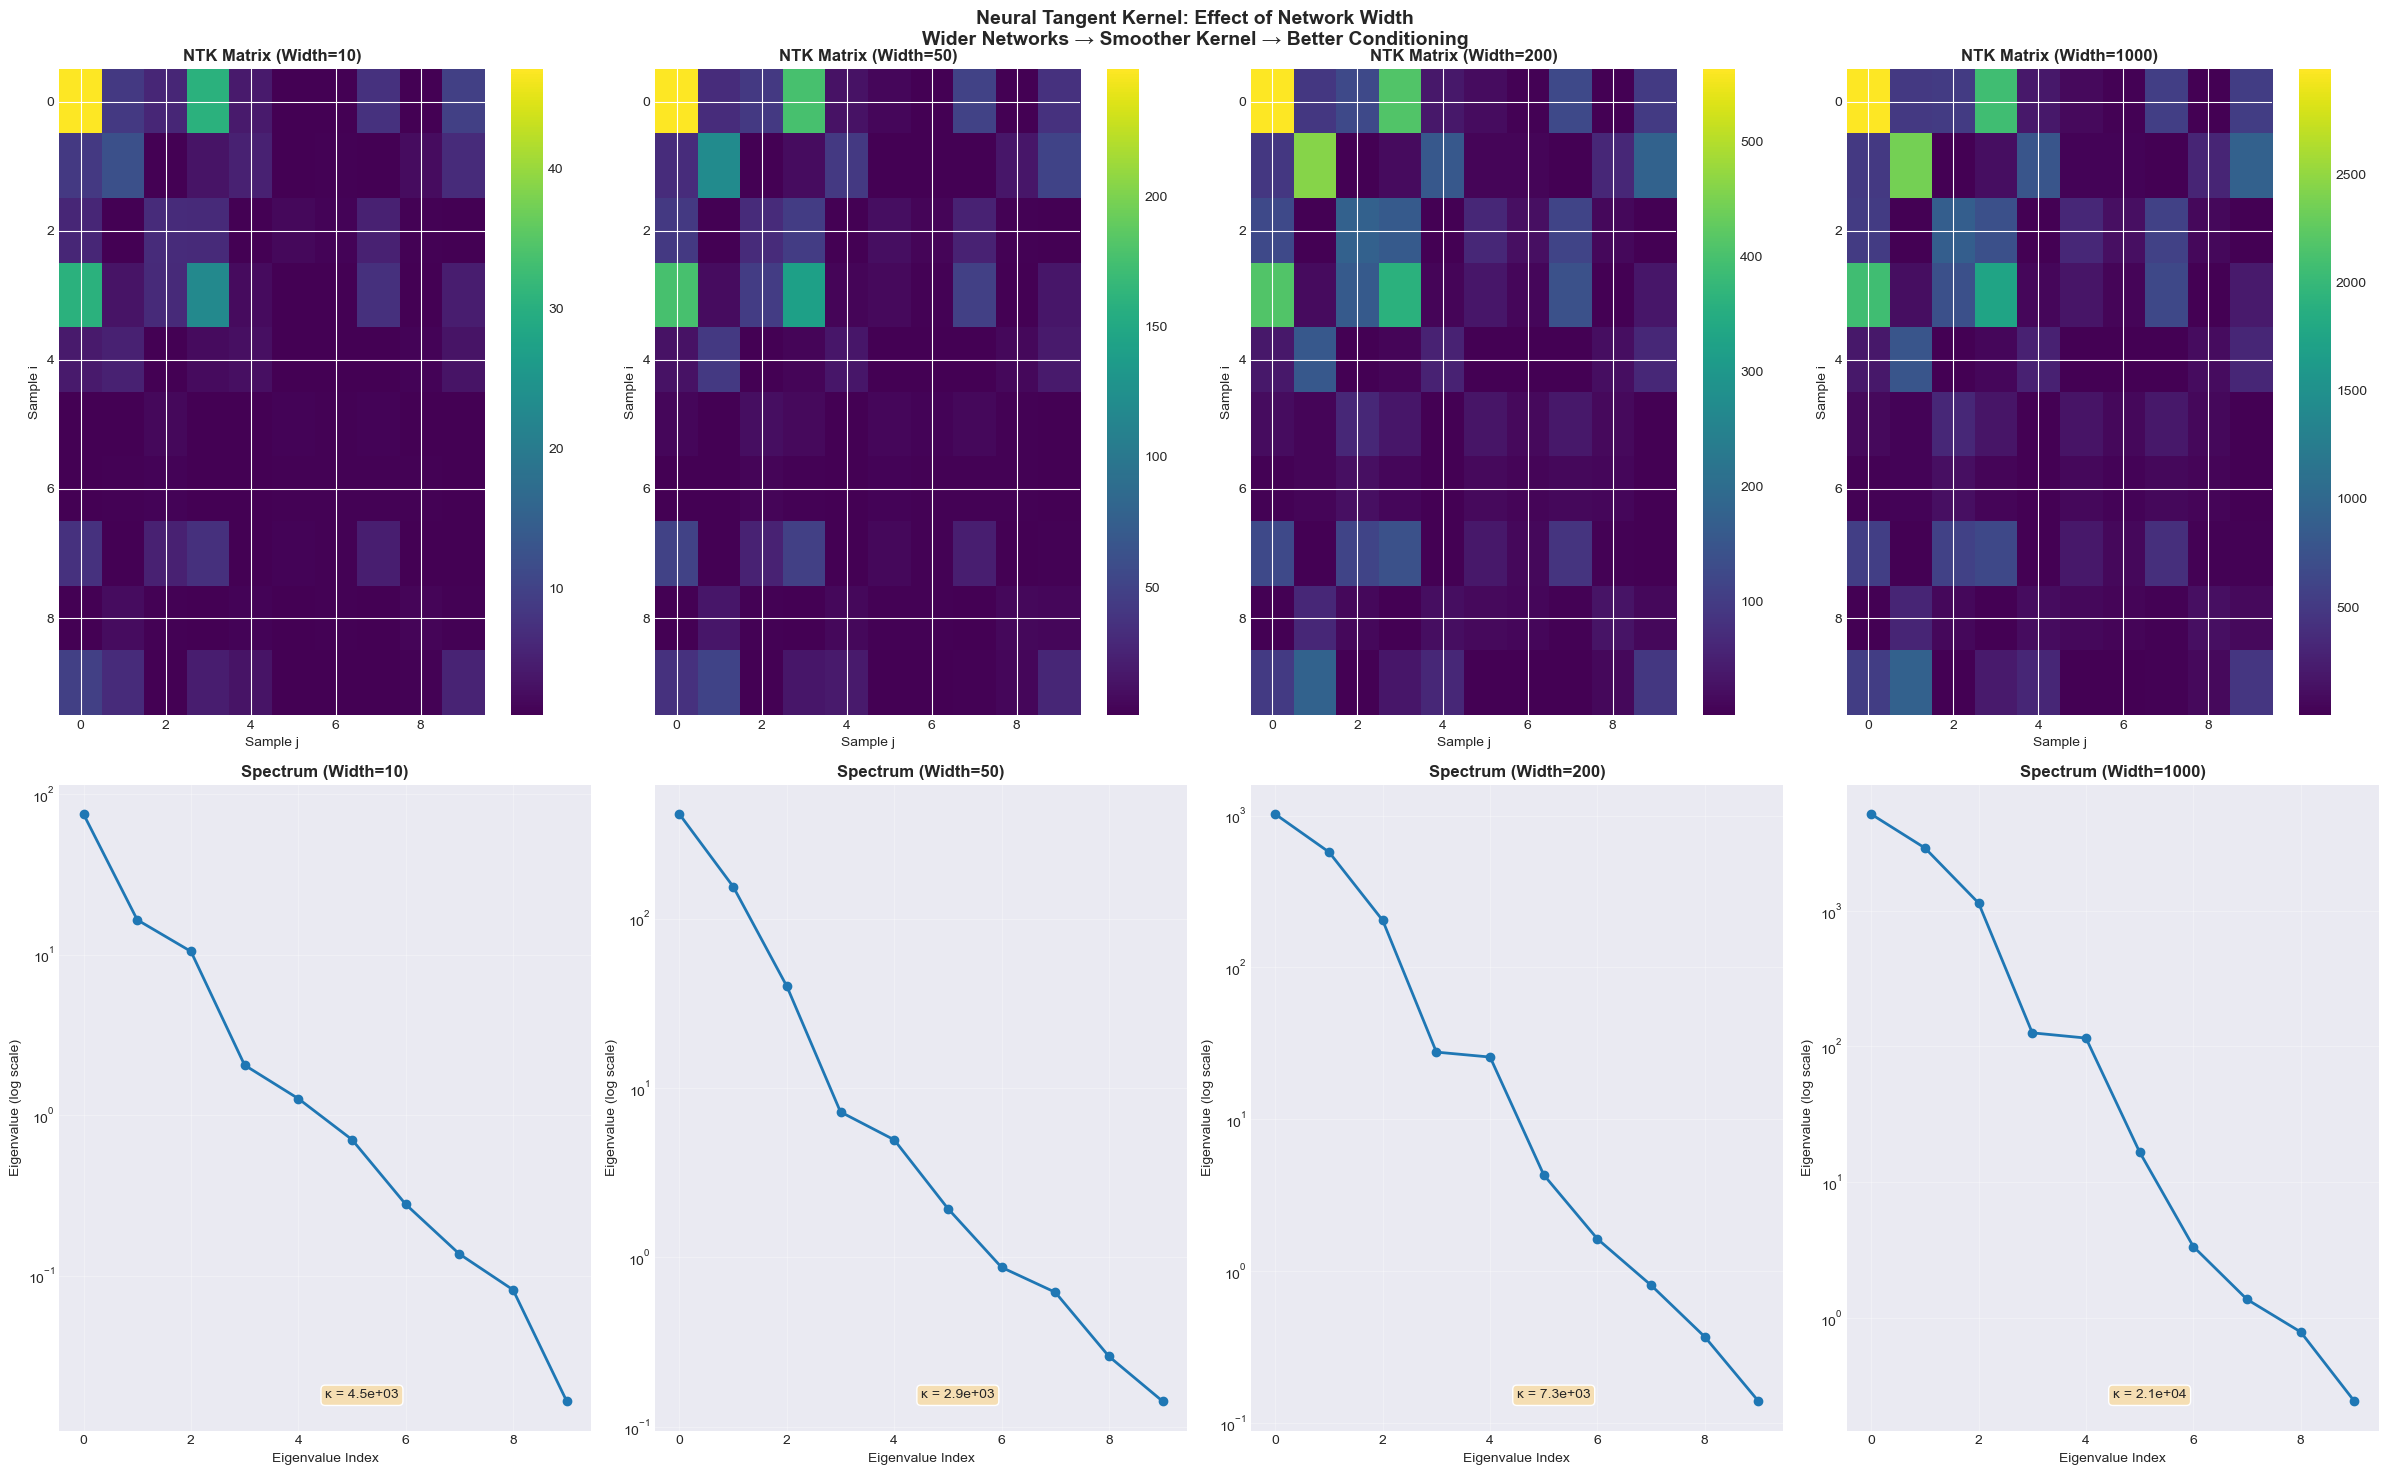

In [12]:
compute_ntk_matrix()


In [13]:
# %%
def ntk_training_dynamics():
    """
    Demonstrate NTK training dynamics equation
    """

    # Simplified 1D example for clarity
    n_samples = 20
    X = np.linspace(-2, 2, n_samples)
    y = np.sin(2 * X) + 0.1 * np.random.randn(n_samples)

    # Construct a simple kernel (RBF-like for visualization)
    # In reality, this would be computed from network gradients
    def rbf_kernel(x1, x2, width):
        # Width parameter affects kernel behavior
        length_scale = 1.0 / np.sqrt(width)
        dist_sq = (x1[:, None] - x2[None, :])**2
        return np.exp(-dist_sq / (2 * length_scale**2))

    # Different "network widths" (simulated)
    widths = [10, 100, 1000]

    fig, axes = plt.subplots(2, 3, figsize=(24, 15))

    for idx, width in enumerate(widths):
        # Compute kernel matrix
        K = rbf_kernel(X, X, width)

        # Add small regularization for numerical stability
        K_reg = K + 1e-6 * np.eye(n_samples)

        # Initial function values (random)
        f0 = 0.1 * np.random.randn(n_samples)

        # Solve ODE: df/dt = -K(f - y)
        # Analytical solution: f(t) = y + exp(-Kt)(f0 - y)

        # Time points
        t_values = np.linspace(0, 5, 100)

        # Evolution of function values
        f_evolution = []
        for t in t_values:
            exp_Kt = np.linalg.matrix_power(np.eye(n_samples) - 0.01 * K_reg, int(100 * t))
            f_t = y + exp_Kt @ (f0 - y)
            f_evolution.append(f_t)

        f_evolution = np.array(f_evolution)

        # Top row: Kernel matrix
        ax = axes[0, idx]
        im = ax.imshow(K, cmap='viridis', aspect='auto')
        ax.set_title(f'Kernel Matrix (Width={width})', fontweight='bold')
        ax.set_xlabel('x_j')
        ax.set_ylabel('x_i')
        plt.colorbar(im, ax=ax)

        # Bottom row: Training dynamics
        ax = axes[1, idx]

        # Plot evolution at different times
        times_to_plot = [0, 10, 20, 50, 99]
        colors = plt.cm.coolwarm(np.linspace(0, 1, len(times_to_plot)))

        for t_idx, color in zip(times_to_plot, colors):
            ax.plot(X, f_evolution[t_idx], '-', color=color, alpha=0.7,
                   label=f't={t_values[t_idx]:.1f}')

        ax.scatter(X, y, color='black', s=30, alpha=0.5, label='Target')
        ax.set_xlabel('x')
        ax.set_ylabel('f(x)')
        ax.set_title(f'Function Evolution (Width={width})', fontweight='bold')
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3)

    plt.suptitle('NTK Training Dynamics: df/dt = -Θ(f - y)\n'
                 'Wider Networks → Smoother Interpolation',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\nNTK Training Dynamics:")
    print("="*60)
    print("Continuous gradient flow: dθ/dt = -∇L(θ)")
    print("Function space dynamics: df/dt = -Θ(f - y)")
    print("\nWhere Θ is the NTK matrix:")
    print("  Θ(x,x') = <∇_θf(x), ∇_θf(x')>")
    print("\nSolution: f(t) = f(0) + Θ(I - exp(-Θt))Θ^(-1)(y - f(0))")
    print("\nAs t → ∞: f(∞) = f(0) + ΘΘ^(-1)(y - f(0)) = y (perfect fit)")
    print("="*60)


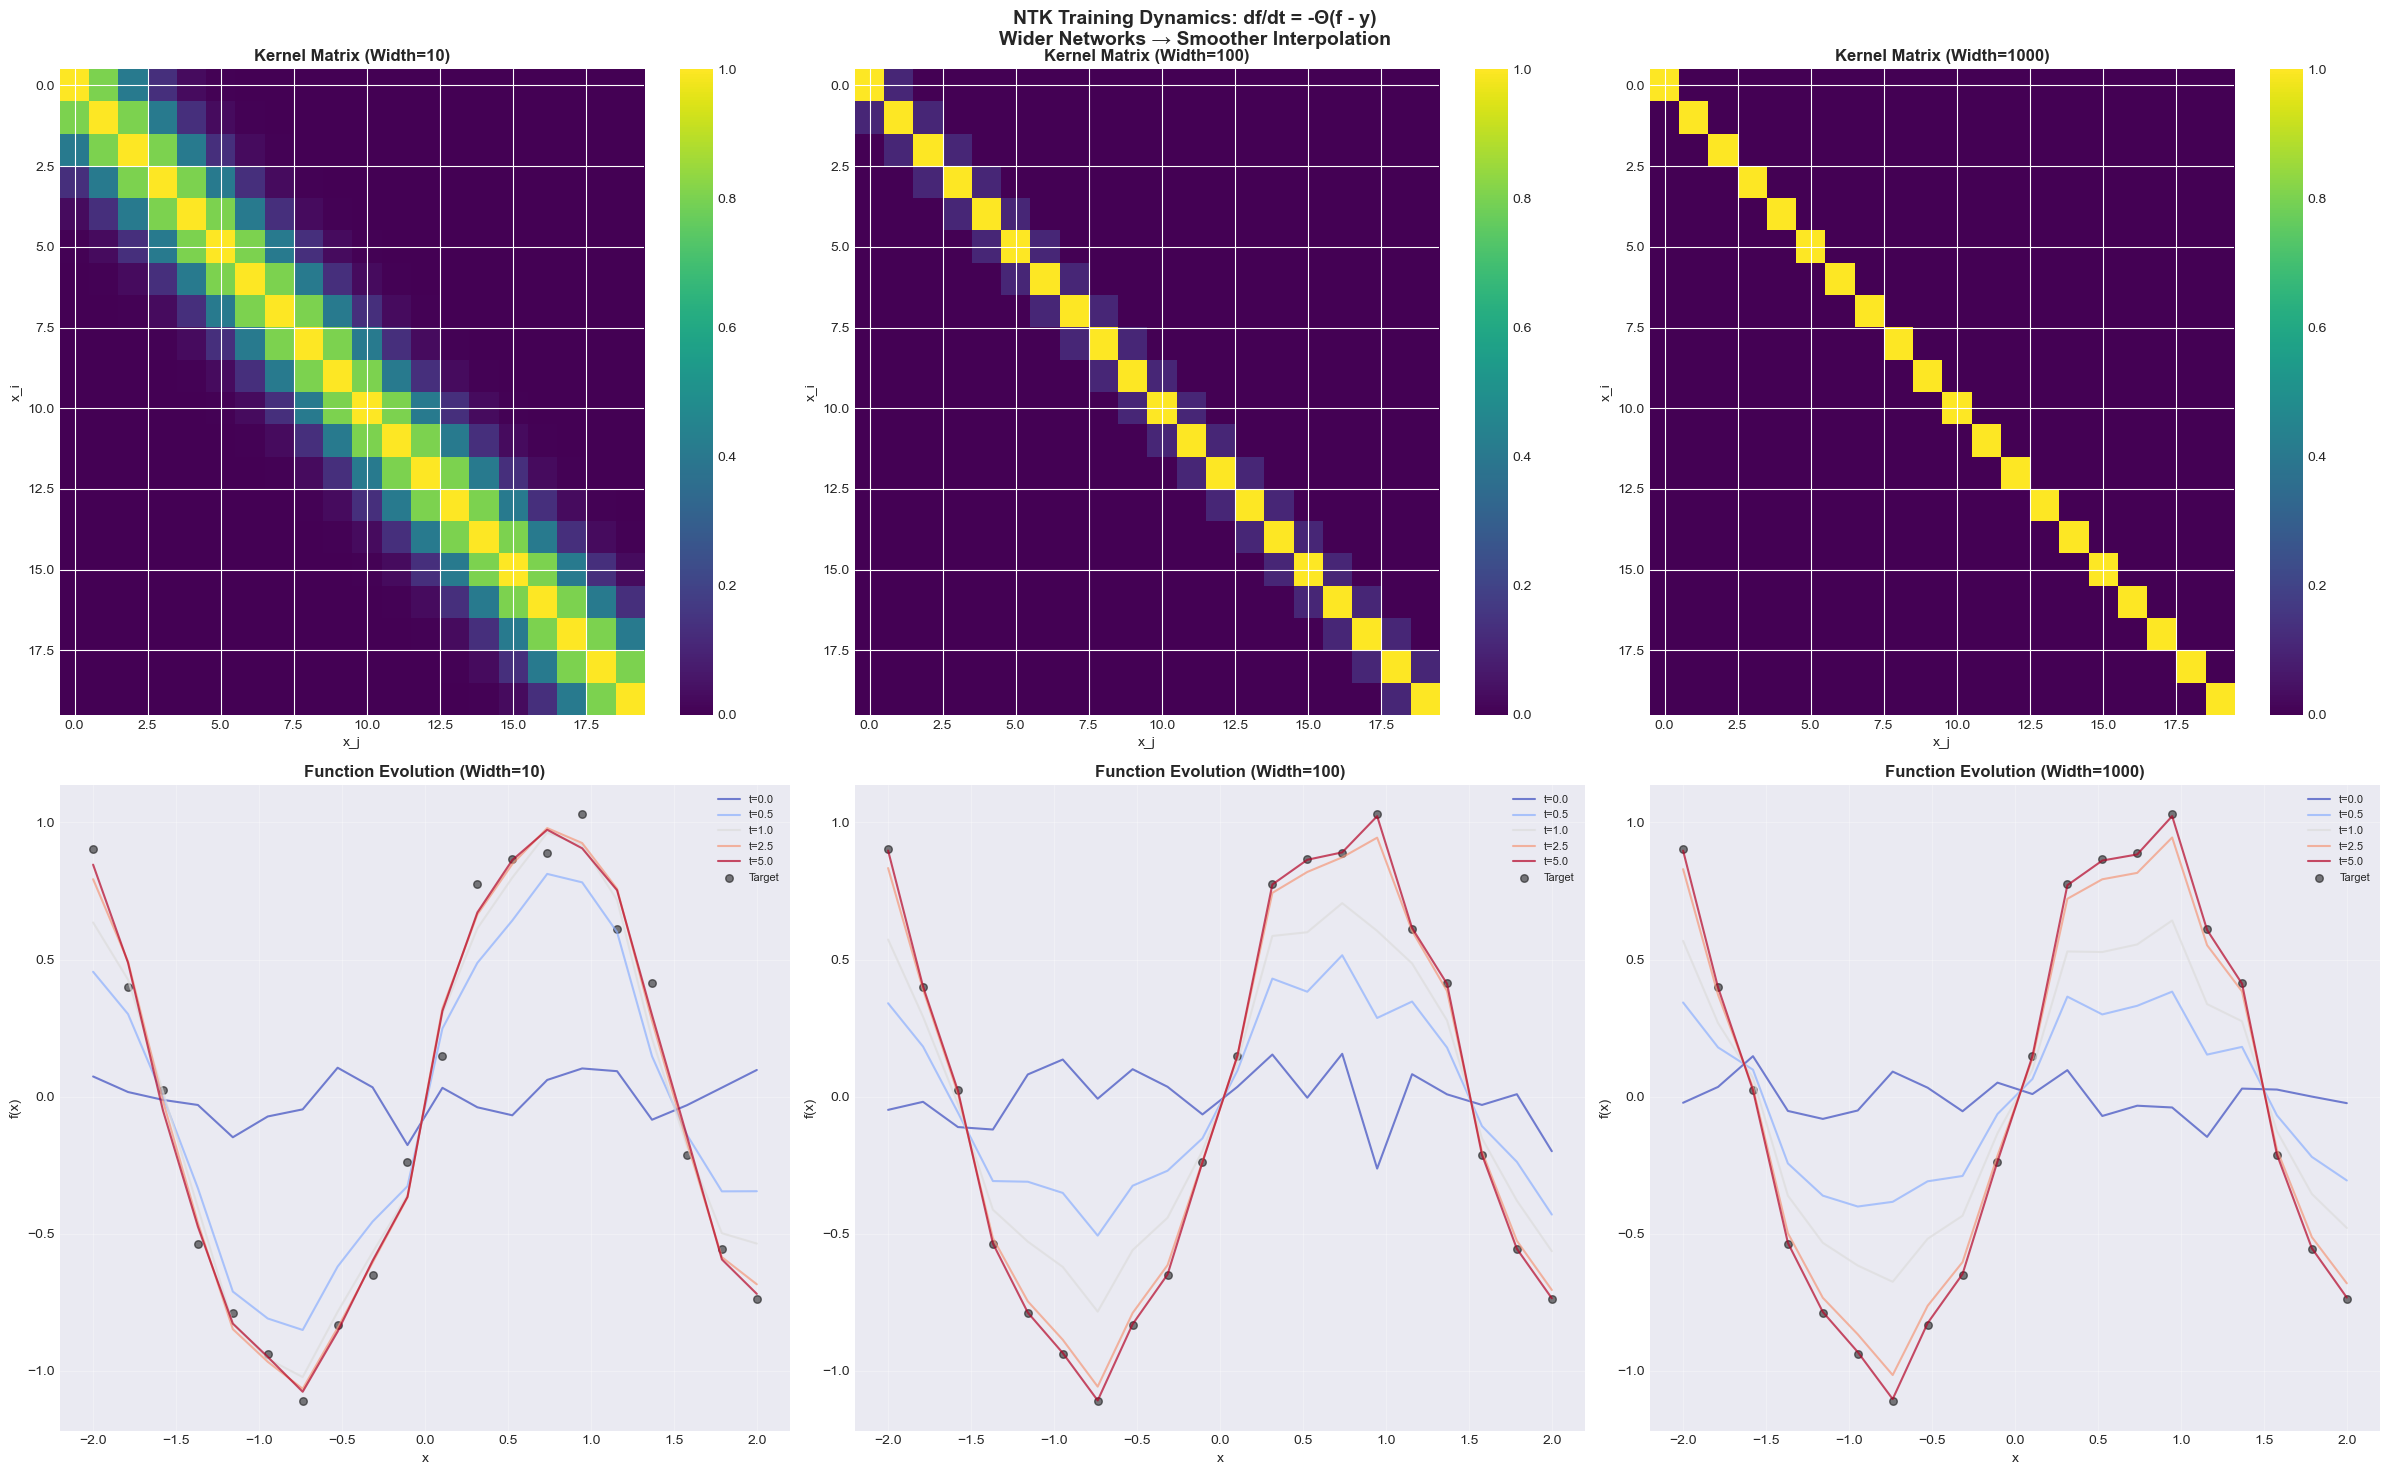


NTK Training Dynamics:
Continuous gradient flow: dθ/dt = -∇L(θ)
Function space dynamics: df/dt = -Θ(f - y)

Where Θ is the NTK matrix:
  Θ(x,x') = <∇_θf(x), ∇_θf(x')>

Solution: f(t) = f(0) + Θ(I - exp(-Θt))Θ^(-1)(y - f(0))

As t → ∞: f(∞) = f(0) + ΘΘ^(-1)(y - f(0)) = y (perfect fit)


In [14]:
ntk_training_dynamics()


In [15]:
# %%
def width_vs_feature_learning():
    """
    Demonstrate how network width affects feature learning
    """

    widths = np.logspace(1, 4, 50)  # 10 to 10,000

    # Model: feature learning strength decreases with width
    # Based on empirical observations and theory
    feature_learning = 1.0 / np.sqrt(widths)
    kernel_behavior = 1.0 - feature_learning
    optimization_ease = 1.0 - np.exp(-widths / 100)  # Saturates

    fig, axes = plt.subplots(1, 3, figsize=(21, 9))

    # Feature learning vs width
    ax = axes[0]
    ax.loglog(widths, feature_learning, 'b-', linewidth=3, label='Feature Learning')
    ax.loglog(widths, kernel_behavior, 'r--', linewidth=3, label='Kernel Behavior')
    ax.set_xlabel('Network Width', fontsize=12)
    ax.set_ylabel('Strength', fontsize=12)
    ax.set_title('Feature Learning vs Kernel Regime', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axvline(100, color='gray', linestyle=':', alpha=0.5)
    ax.text(100, 0.01, 'Typical\nNN', ha='center', fontsize=10)

    # Optimization ease vs width
    ax = axes[1]
    ax.semilogx(widths, optimization_ease, 'g-', linewidth=3)
    ax.set_xlabel('Network Width', fontsize=12)
    ax.set_ylabel('Optimization Ease', fontsize=12)
    ax.set_title('Easier Optimization with Width', fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(0.9, color='gray', linestyle='--', alpha=0.5)

    # The tradeoff
    ax = axes[2]
    generalization = feature_learning * 0.7 + optimization_ease * 0.3
    ax.semilogx(widths, feature_learning, 'b-', linewidth=2, alpha=0.5, label='Feature Learning')
    ax.semilogx(widths, optimization_ease, 'g-', linewidth=2, alpha=0.5, label='Optimization')
    ax.semilogx(widths, generalization, 'purple', linewidth=3, label='Generalization')

    # Find and mark optimum
    optimal_idx = np.argmax(generalization)
    ax.scatter(widths[optimal_idx], generalization[optimal_idx],
              color='red', s=100, zorder=5)
    ax.axvline(widths[optimal_idx], color='red', linestyle=':', alpha=0.5)

    ax.set_xlabel('Network Width', fontsize=12)
    ax.set_ylabel('Performance', fontsize=12)
    ax.set_title('The Sweet Spot', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.text(widths[optimal_idx], 0.1, f'Optimal\n≈{widths[optimal_idx]:.0f}',
           ha='center', fontsize=10, color='red')

    plt.suptitle('Width Tradeoff: Feature Learning vs Optimization Ease',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\nKey Insights:")
    print("="*60)
    print("Narrow Networks (width < 100):")
    print("  ✓ Strong feature learning")
    print("  ✗ Difficult optimization")
    print("  → May get stuck in bad minima")
    print()
    print("Wide Networks (width > 1000):")
    print("  ✓ Easy optimization (convex-like)")
    print("  ✗ Weak feature learning")
    print("  → May not learn good representations")
    print()
    print("Sweet Spot (width ≈ 100-1000):")
    print("  ✓ Sufficient feature learning")
    print("  ✓ Tractable optimization")
    print("  → Best generalization!")
    print("="*60)


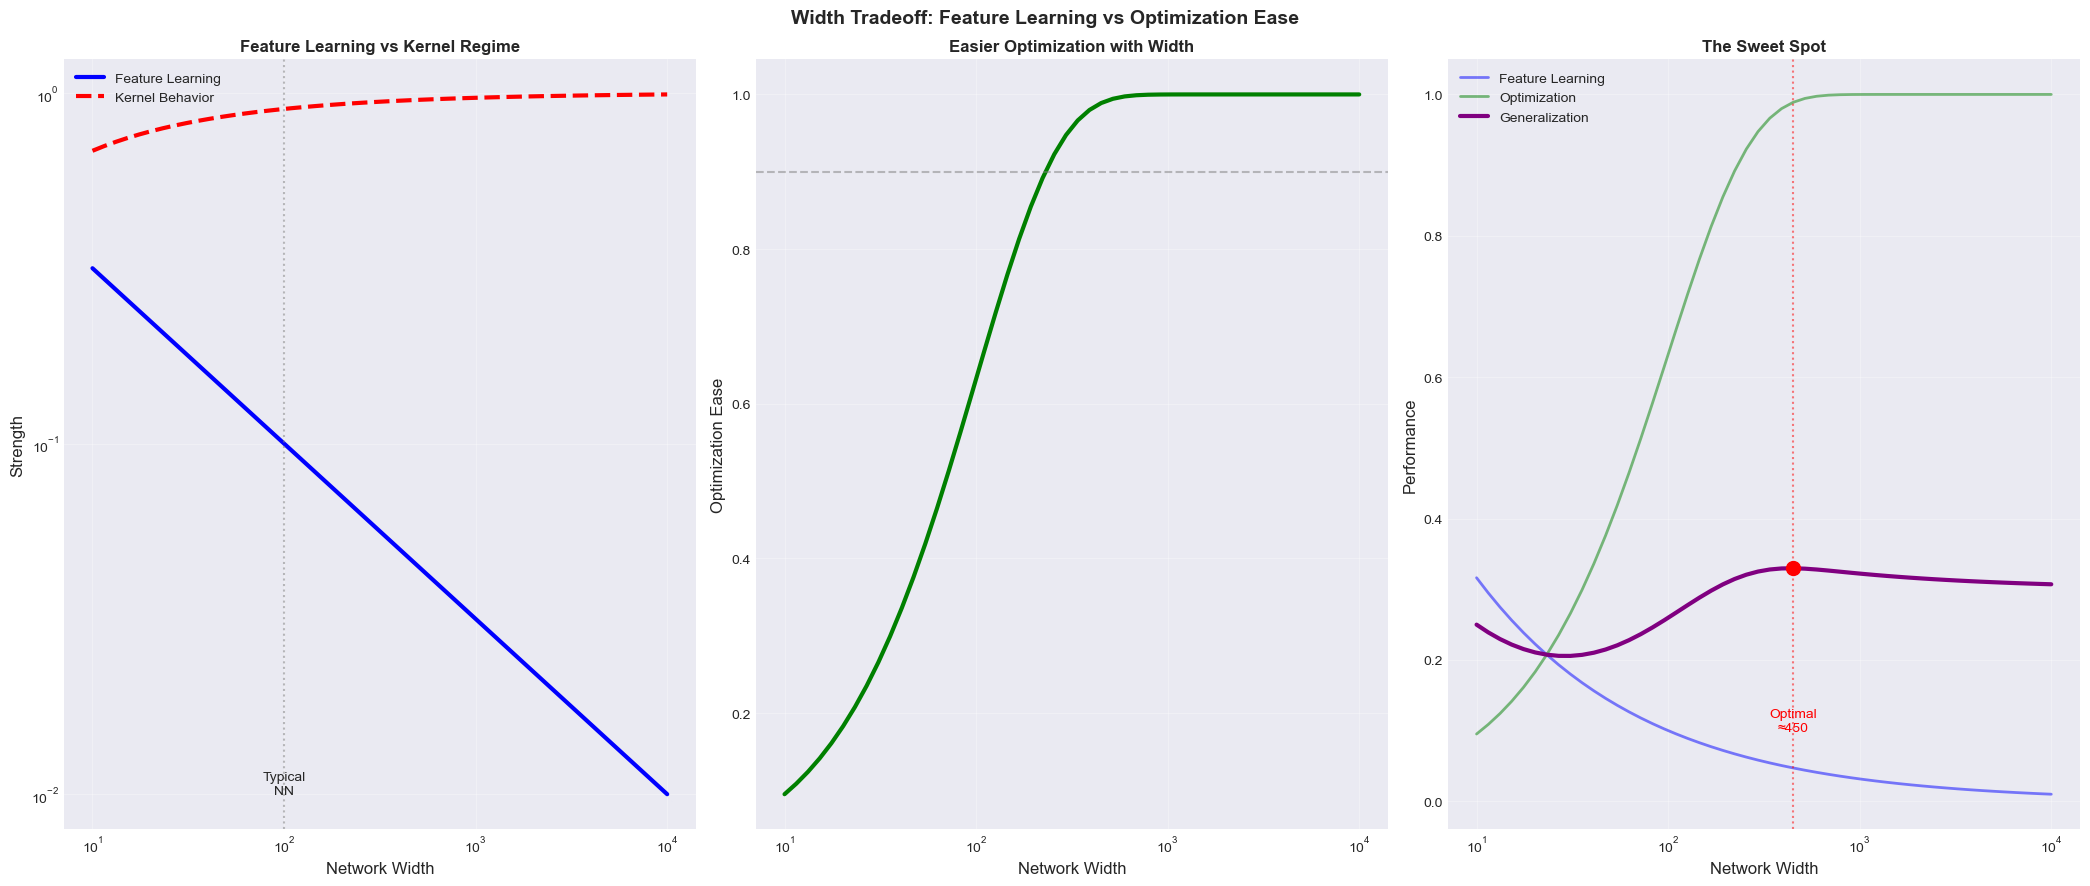


Key Insights:
Narrow Networks (width < 100):
  ✓ Strong feature learning
  ✗ Difficult optimization
  → May get stuck in bad minima

Wide Networks (width > 1000):
  ✓ Easy optimization (convex-like)
  ✗ Weak feature learning
  → May not learn good representations

Sweet Spot (width ≈ 100-1000):
  ✓ Sufficient feature learning
  ✓ Tractable optimization
  → Best generalization!


In [16]:
width_vs_feature_learning()


In [17]:
# %% [markdown]
# ## 4. Unified View: All Three Perspectives

# %%
def unified_visualization():
    """
    Show how MAP, Lottery Tickets, and NTK all explain overparameterization
    """

    fig = plt.figure(figsize=(24, 15))

    # Create custom grid
    gs = fig.add_gridspec(3, 4, hspace=0.4, wspace=0.3)

    # Title
    ax_title = fig.add_subplot(gs[0, :])
    ax_title.text(0.5, 0.7, 'Three Perspectives on Overparameterization',
                  fontsize=18, fontweight='bold', ha='center')
    ax_title.text(0.5, 0.3, 'All lead to: Better Optimization + Better Generalization',
                  fontsize=14, ha='center', style='italic', color='darkblue')
    ax_title.axis('off')

    # MAP/Regularization perspective
    ax1 = fig.add_subplot(gs[1, 0])
    params = np.linspace(10, 10000, 100)
    effective_reg = 1.0 / np.sqrt(params)  # Implicit regularization
    ax1.semilogx(params, effective_reg, 'b-', linewidth=3)
    ax1.set_xlabel('# Parameters')
    ax1.set_ylabel('Effective Regularization')
    ax1.set_title('MAP: Implicit Regularization', fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Lottery Ticket perspective
    ax2 = fig.add_subplot(gs[1, 1])
    p_lottery = 1 - np.exp(-params / 1000)
    ax2.semilogx(params, p_lottery, 'g-', linewidth=3)
    ax2.set_xlabel('# Parameters')
    ax2.set_ylabel('P(Good Initialization)')
    ax2.set_title('Lottery: More Tickets', fontweight='bold')
    ax2.grid(True, alpha=0.3)

    # NTK perspective
    ax3 = fig.add_subplot(gs[1, 2])
    kernel_cond = 100 / np.sqrt(params)  # Condition number improves
    ax3.loglog(params, kernel_cond, 'r-', linewidth=3)
    ax3.set_xlabel('# Parameters')
    ax3.set_ylabel('Condition Number')
    ax3.set_title('NTK: Better Conditioning', fontweight='bold')
    ax3.grid(True, alpha=0.3)

    # Combined effect
    ax4 = fig.add_subplot(gs[1, 3])
    combined = (1 - effective_reg) * p_lottery * (1 - kernel_cond/100)
    ax4.semilogx(params, combined, 'purple', linewidth=4)
    ax4.fill_between(params, 0, combined, alpha=0.3, color='purple')
    ax4.set_xlabel('# Parameters')
    ax4.set_ylabel('Overall Benefit')
    ax4.set_title('Combined Effect', fontweight='bold')
    ax4.grid(True, alpha=0.3)

    # Mathematical summary
    ax_math = fig.add_subplot(gs[2, :])
    math_text = """
    Mathematical Unification:

    • MAP:     L = L_data + λ||θ||²,  where λ ∝ 1/width  →  Flatter minima
    • Lottery: P(success) = 1 - (1-p)^C(n,k),  where C(n,k) ∝ width  →  Better initialization
    • NTK:     Θ(x,x') = <∇θf(x), ∇θf(x')>,  where cond(Θ) ∝ 1/√width  →  Easier optimization

    Conclusion: Overparameterization helps through multiple independent mechanisms!
    """
    ax_math.text(0.1, 0.5, math_text, fontsize=12, family='monospace',
                verticalalignment='center')
    ax_math.axis('off')

    plt.suptitle('The Overparameterization Phenomenon: A Unified View',
                 fontsize=16, fontweight='bold', y=0.98)
    plt.show()


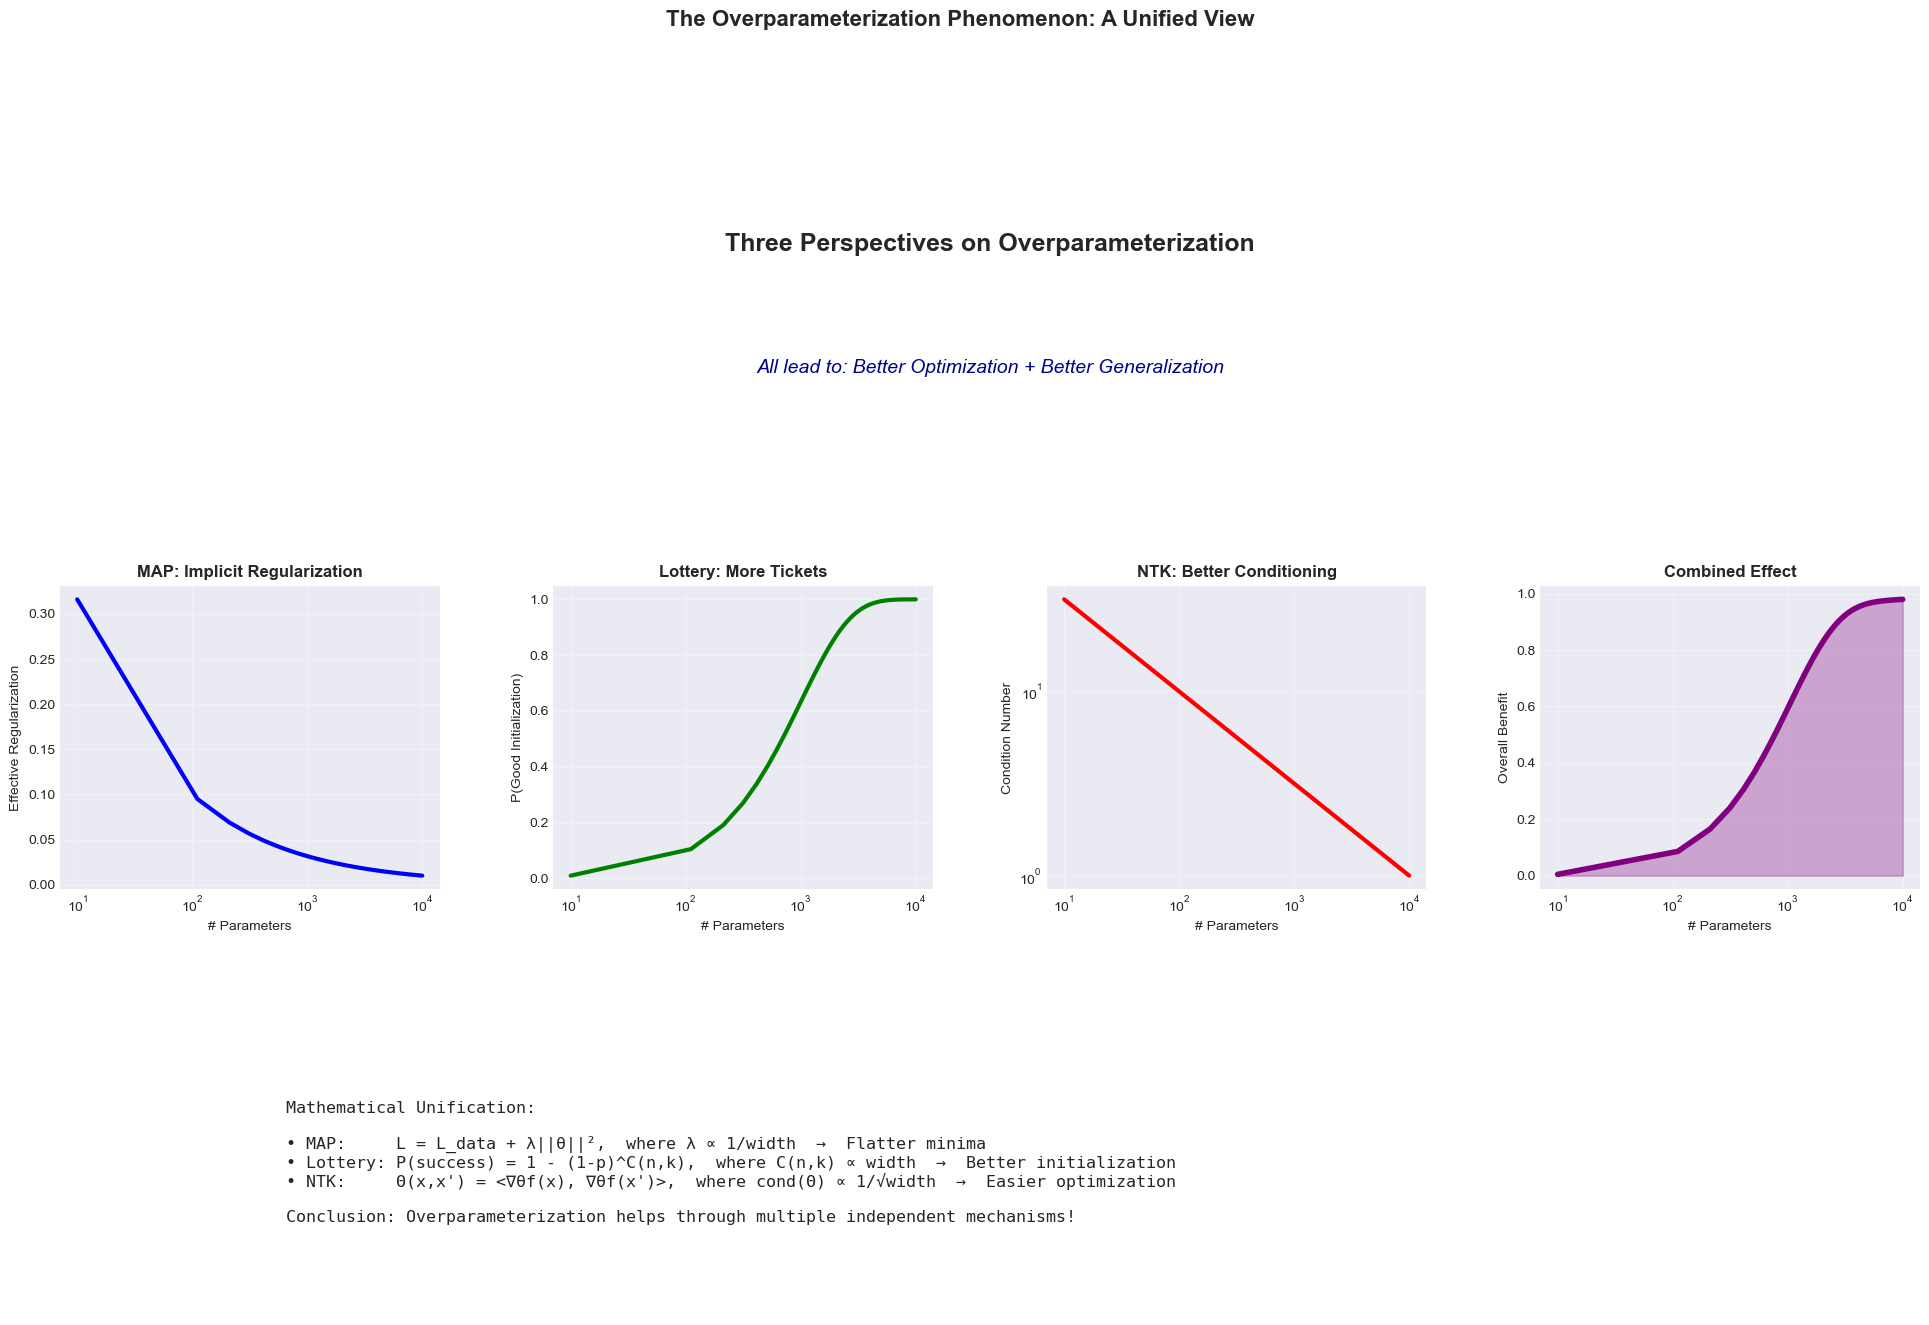


Summary: Three Complementary Perspectives
1. MAP/Bayesian View: More parameters → better implicit regularization
2. Lottery Ticket View: More parameters → higher chance of good subnetworks
3. NTK View: More parameters → smoother optimization landscape

All three are correct and explain different aspects of the same phenomenon!


In [18]:
unified_visualization()

print("\n" + "="*60)
print("Summary: Three Complementary Perspectives")
print("="*60)
print("1. MAP/Bayesian View: More parameters → better implicit regularization")
print("2. Lottery Ticket View: More parameters → higher chance of good subnetworks")
print("3. NTK View: More parameters → smoother optimization landscape")
print("\nAll three are correct and explain different aspects of the same phenomenon!")
print("="*60)